# Explore here

In [1]:
# Your code here

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
data = pd.read_csv(url)
print(f"Shape: {data.shape}")
print("\nData Types & Missing Values:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe(include='all'))


Shape: (1338, 7)

Data Types & Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Summary Statistics:
                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397    

# # Analysis of Results:

# 1338 rows × 7 columns: 
Good sample size for regression

# No missing values:
Excellent - no imputation needed

# Data types:

Numerical: age, bmi, children, charges

Categorical: sex, smoker, region

Target variable (charges):

Mean ($13,270) > Median ($9,382) → Right-skewed distribution

Huge range: $1,122 - $63,770 → Potential outliers

In [3]:
print(f"Duplicates before: {data.duplicated().sum()}")
data = data.drop_duplicates()
print(f"Duplicates after: {data.duplicated().sum()}")

Duplicates before: 1
Duplicates after: 0


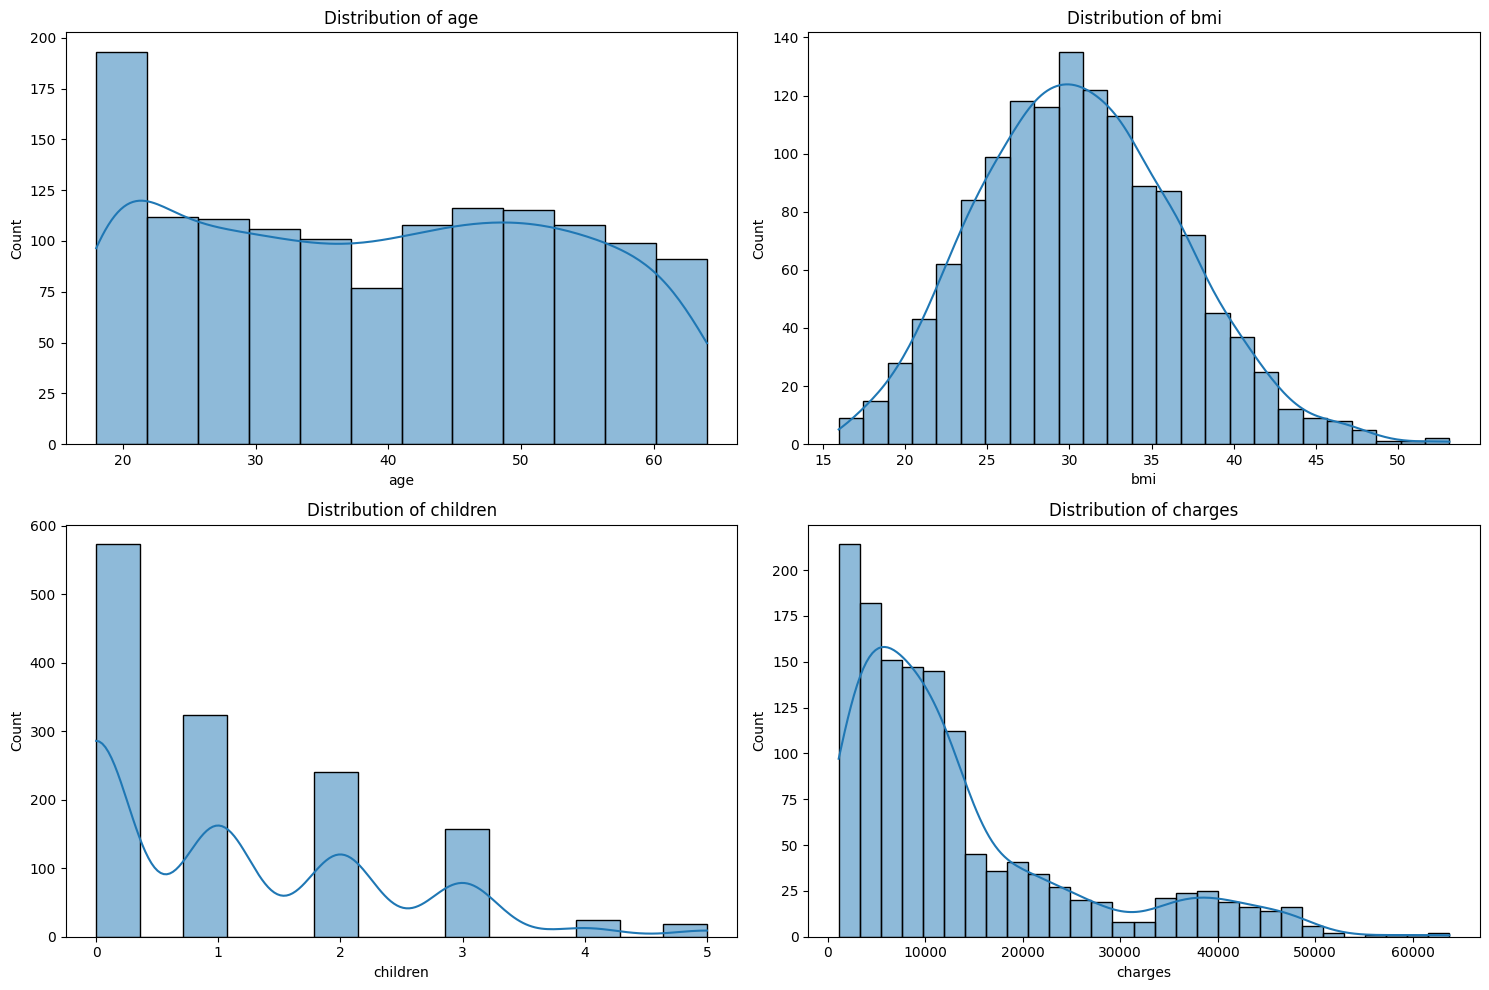

In [4]:
num_cols = ['age', 'bmi', 'children', 'charges']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(num_cols):
    ax = axes[i//2, i%2]
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

## Analysis of Results:

# age:

Bimodal distribution (peaks at 20s and 50s)

Insight: Represents two key insurance demographics

Action: Consider polynomial terms in regression

# bmi:

Approximately normal (mean: 30.66)

Slight right skew → Most insured are overweight

Action: Watch for obesity premium effects

# children:

Discrete count data

Skewed right: 43% have no children

Action: May benefit from binary encoding (has children vs not)

# charges:

Severe right skew

Key Insight: Will violate linear regression normality assumption

Critical Action: Must log-transform for regression



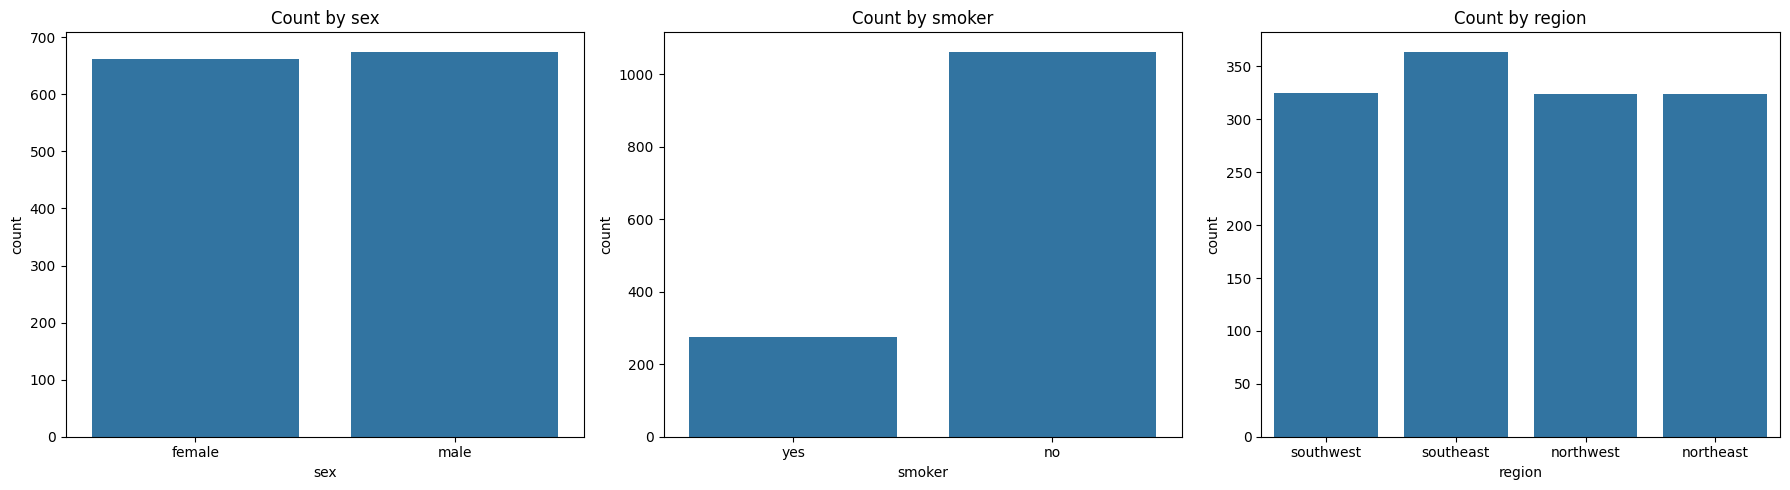

In [5]:
cat_cols = ['sex', 'smoker', 'region']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(cat_cols):
    sns.countplot(x=data[col], ax=axes[i])
    axes[i].set_title(f'Count by {col}')
    
plt.tight_layout()
plt.show()

## Analysis of Results:

# sex:

Near-perfect balance (50.5% male)

Action: Simple one-hot encoding sufficient

# smoker:

Severe imbalance: 79.5% non-smokers

Critical Insight: Will be dominant predictor

Action: Must create interaction terms

# region:

Fairly balanced (24-27% per region)

Insight: Southeast slightly overrepresented

Action: Combine if model complexity needs reduction

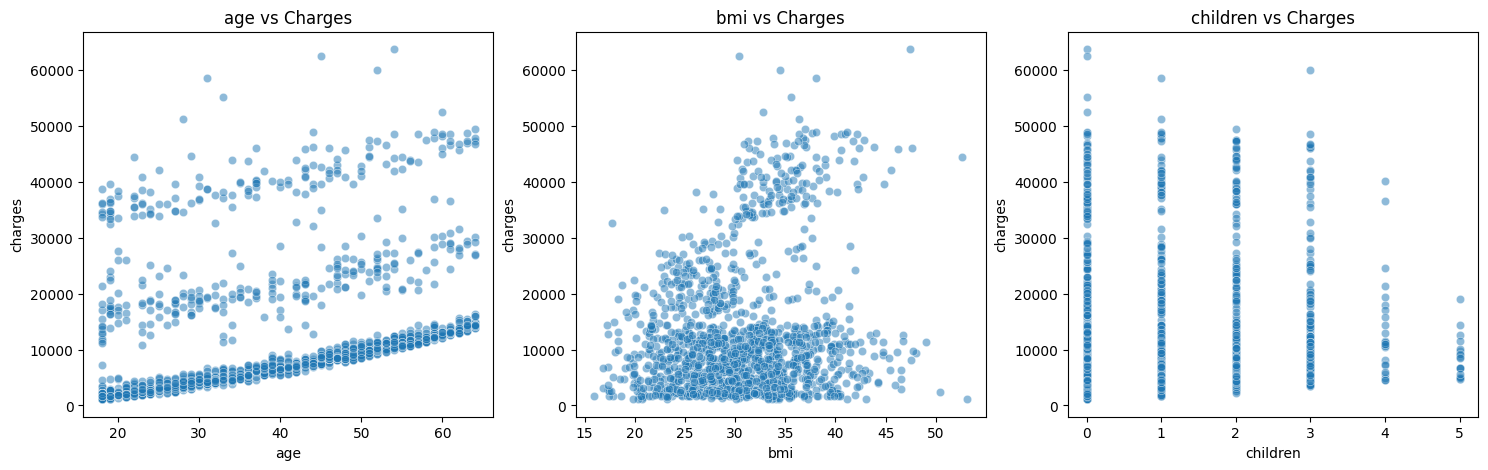

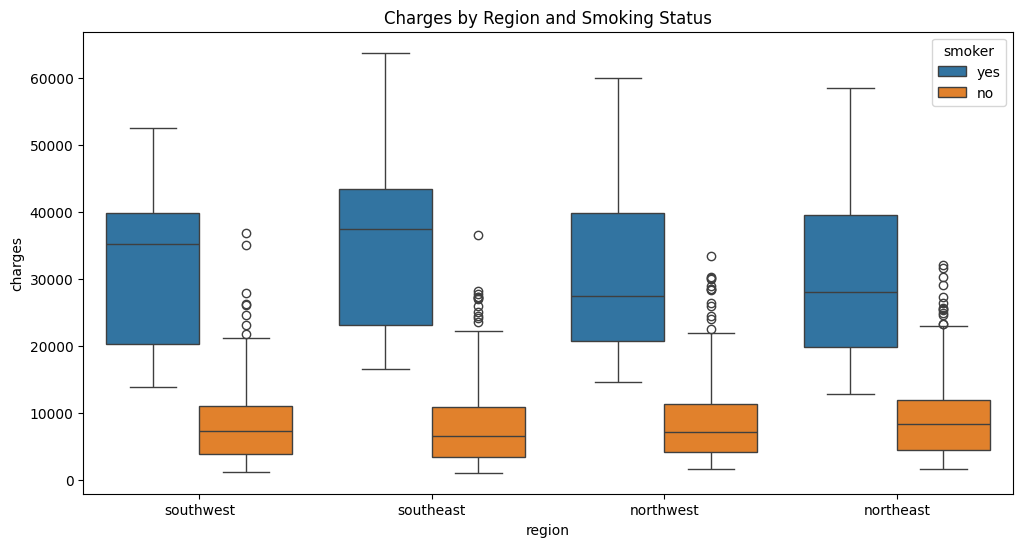

In [6]:
# Numerical features vs charges
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['age', 'bmi', 'children']):
    sns.scatterplot(x=data[col], y=data['charges'], alpha=0.5, ax=axes[i])
    axes[i].set_title(f'{col} vs Charges')

# Categorical features vs charges
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='charges', hue='smoker', data=data)
plt.title('Charges by Region and Smoking Status')
plt.show()

## Analysis of Results:

# age vs charges:

Positive correlation with distinct stratification

Critical Insight: Two parallel lines → smoker effect

Action: Must create smoker-age interaction term

# smoker effect:

Overwhelming impact: Smokers pay 3-4x more

Median charge: Smokers = $34,000 vs Non-smokers = $8,500

Business Insight: Most important pricing factor

# bmi vs charges:

Weak positive trend overall

Threshold effect: Sharp increase when BMI > 30 (obese)

Action: Create BMI categories or quadratic term

# children:

No clear linear relationship

Insight: Having children ≠ higher premiums

Action: Simplify to binary (has children or not)

# region:

Southeast has highest premiums (especially smokers)

Action: Include but expect small coefficient

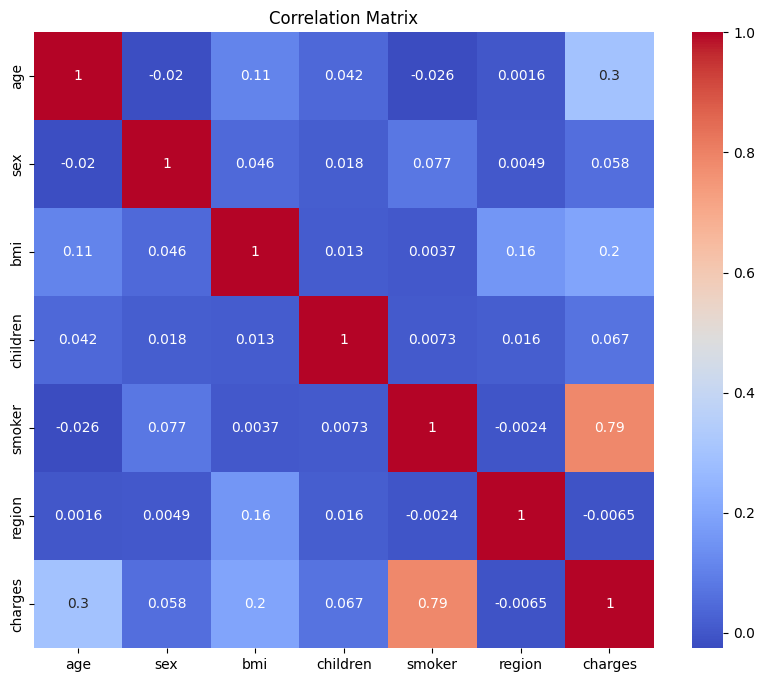

In [7]:
# Encode categoricals for correlation matrix
from sklearn.preprocessing import LabelEncoder
data_encoded = data.copy()
le = LabelEncoder()
for col in cat_cols:
    data_encoded[col] = le.fit_transform(data[col])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Analysis of Results:

# smoker → charges: +0.79

Strongest predictor by far

Validates boxplot observations

# age → charges: +0.30

Moderate positive correlation

Will be stronger when interacting with smoker

# bmi → charges: +0.20

Weak but significant correlation

Will be stronger for obese individuals

# No concerning multicollinearity between predictors

All |r| < 0.3 except smoker-charges

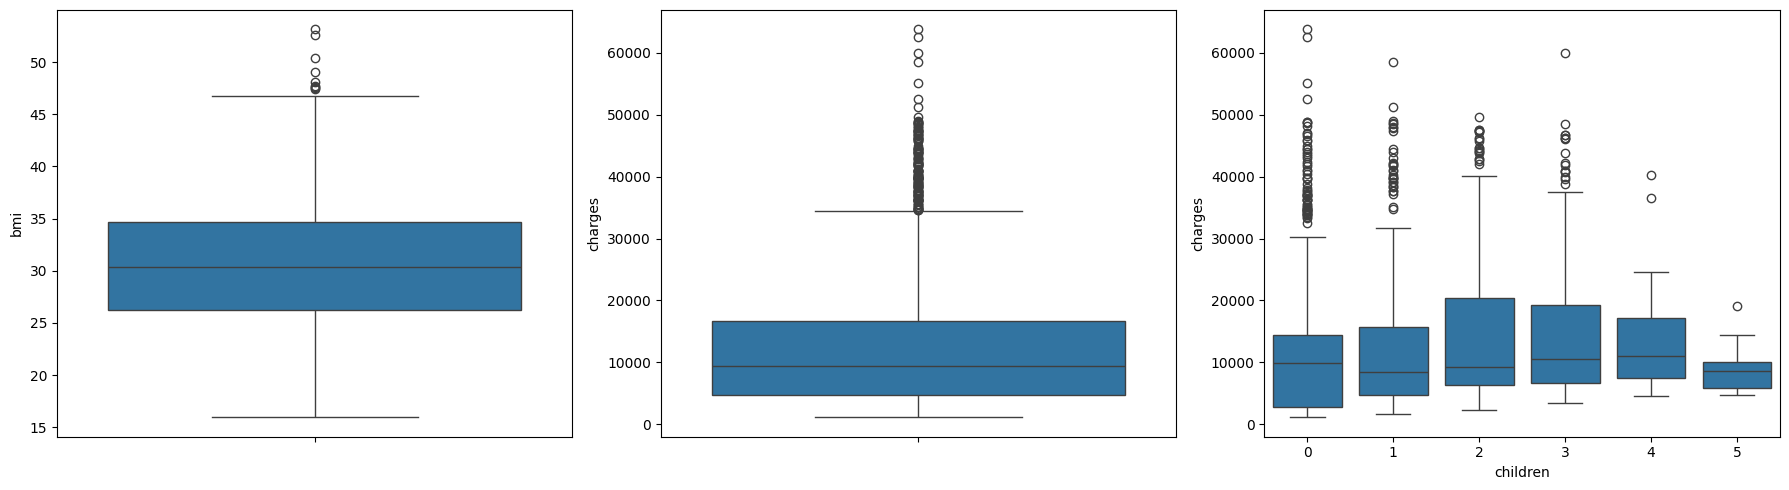

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(y='bmi', data=data, ax=axes[0])
sns.boxplot(y='charges', data=data, ax=axes[1])
sns.boxplot(x='children', y='charges', data=data, ax=axes[2])
plt.tight_layout()
plt.show()

## Analysis of Results:

# bmi outliers:

Valid medical cases (severe obesity)

Action: Retain - they represent high-risk insureds

# charges outliers:

Correspond to older smokers with high BMI

Action: Retain - legitimate high-cost cases

Mitigation: Use log transformation

# No problematic outliers requiring removal



In [9]:
data['smoker_age'] = data['age'] * data['smoker'].map({'yes': 1, 'no': 0})

In [10]:
data['bmi_category'] = pd.cut(data['bmi'], 
                              bins=[0, 18.5, 25, 30, 100],
                              labels=['underweight', 'normal', 'overweight', 'obese'])

In [11]:
data['has_children'] = (data['children'] > 0).astype(int)

In [12]:
data['log_charges'] = np.log1p(data['charges'])

NameError: name 'np' is not defined

In [ ]:
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region', 'bmi_category'], drop_first=True)

# log_charges:
Fixes skew for regression assumptions

# smoker_age:
Captures critical interaction observed in scatterplots

# bmi_category: 
Models non-linear BMI effects efficiently

# has_children: 
Simplifies weak predictor

# drop_first: 
Avoids dummy variable trap